# Chapter 5 exercises

## pytorch implementation

In [1]:
# Import necessary libraries
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

In [2]:


# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST(root='./data/mnist', train=True, download=True, transform=transform)
val_dataset = MNIST(root='./data/mnist', train=False, download=True, transform=transform)

# Define the DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)

# Iterate through the DataLoader
for images, labels in train_loader:
    print(f'Images batch shape: {images.size()}')
    print(f'Labels batch shape: {labels.size()}')
    break  # Just to demonstrate, break after the first batch

Images batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
# Define a custom layer
class CustomLayer(nn.Module):
    def __init__(self, in_features, out_features, activation):
        super(CustomLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.activation = activation

    def forward(self, x):
        x = self.linear(x)
        x = self.activation(x)
        return x

# Instantiate and test the custom layer
custom_layer = CustomLayer(28 * 28, 128, F.relu)
print(custom_layer)

CustomLayer(
  (linear): Linear(in_features=784, out_features=128, bias=True)
)


In [5]:
# Define a custom neural network using the custom layer
class CustomNN(nn.Module):
    def __init__(self):
        super(CustomNN, self).__init__()
        self.layer1 = CustomLayer(28 * 28, 128, F.relu)
        self.layer2 = CustomLayer(128, 64, F.relu)
        self.output_layer = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input tensor
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.output_layer(x)
        return x

# Instantiate and test the custom neural network
model = CustomNN()
print(model)

CustomNN(
  (layer1): CustomLayer(
    (linear): Linear(in_features=784, out_features=128, bias=True)
  )
  (layer2): CustomLayer(
    (linear): Linear(in_features=128, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=10, bias=True)
)


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the parameters
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy:.2f}%')

print('Finished Training')

Epoch [1/5], Loss: 0.3500
Validation Accuracy: 94.96%
Epoch [2/5], Loss: 0.1389
Validation Accuracy: 96.11%
Epoch [3/5], Loss: 0.0945
Validation Accuracy: 96.81%
Epoch [4/5], Loss: 0.0725
Validation Accuracy: 97.12%
Epoch [5/5], Loss: 0.0568
Validation Accuracy: 97.15%
Finished Training


## jax implementation

In [7]:
import jax
import jax.numpy as jnp
import optax
from jax import random, grad, jit, vmap
from jax.nn import relu, log_softmax
from jax.scipy.special import logsumexp

# Define the neural network
def init_params(key):
    keys = random.split(key, 3)
    params = {
        'W1': random.normal(keys[0], (28 * 28, 128)) * jnp.sqrt(2.0 / (28 * 28)), #kaiming initialization
        'b1': jnp.zeros(128),
        'W2': random.normal(keys[1], (128, 64)) * jnp.sqrt(2.0 / 128),
        'b2': jnp.zeros(64),
        'W3': random.normal(keys[2], (64, 10)) * jnp.sqrt(2.0 / 64),
        'b3': jnp.zeros(10)
    }
    return params

def forward(params, x):
    x = x.reshape(-1, 28 * 28)  # Flatten the input tensor
    x = relu(jnp.dot(x, params['W1']) + params['b1'])
    x = relu(jnp.dot(x, params['W2']) + params['b2'])
    x = jnp.dot(x, params['W3']) + params['b3']
    return x

# Define the loss function
def cross_entropy_loss(logits, labels):
    one_hot_labels = jax.nn.one_hot(labels, num_classes=10)
    return -jnp.mean(jnp.sum(one_hot_labels * log_softmax(logits), axis=-1))

# Define the accuracy function
def accuracy(logits, labels):
    predictions = jnp.argmax(logits, axis=-1)
    return jnp.mean(predictions == labels)

# Define the training step
@jit
def train_step(params, opt_state, images, labels):
    def loss_fn(params):
        logits = forward(params, images)
        loss = cross_entropy_loss(logits, labels)
        return loss

    grads = grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state

# Initialize the model and optimizer
key = random.PRNGKey(0)
params = init_params(key)
optimizer = optax.adam(learning_rate=0.001)
opt_state = optimizer.init(params)

# Training loop
num_epochs = 5
batch_size = 64

for epoch in range(num_epochs):
    # Assuming train_loader is an iterable of (images, labels) batches
    for images, labels in train_loader:
        images = jnp.array(images.numpy())
        labels = jnp.array(labels.numpy())
        params, opt_state = train_step(params, opt_state, images, labels)

    # Compute training loss and accuracy
    train_loss = 0.0
    train_acc = 0.0
    num_batches = 0
    for images, labels in val_loader:
        images = jnp.array(images.numpy())
        labels = jnp.array(labels.numpy())
        logits = forward(params, images)
        train_loss += cross_entropy_loss(logits, labels)
        train_acc += accuracy(logits, labels)
        num_batches += 1

    train_loss /= num_batches
    train_acc /= num_batches
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')

print('Finished Training')

Epoch [1/5], Loss: 0.1374, Accuracy: 0.9604
Epoch [2/5], Loss: 0.1015, Accuracy: 0.9689
Epoch [3/5], Loss: 0.0790, Accuracy: 0.9749
Epoch [4/5], Loss: 0.0772, Accuracy: 0.9775
Epoch [5/5], Loss: 0.0755, Accuracy: 0.9766
Finished Training


### plotting

In [8]:
import matplotlib.pyplot as plt

In [9]:
def plot_images_with_predictions(images, predictions, true_labels):
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    axes = axes.flatten()
    
    for img, pred, true_label, ax in zip(images, predictions, true_labels, axes):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f'Pred: {pred}, True: {true_label}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [10]:
#get batch of data
images, labels = next(iter(val_loader))
#convert to jax array
images = jnp.array(images.numpy())
labels = jnp.array(labels.numpy())
# make predictions
logits = forward(params, images)
predictions = jnp.argmax(logits, axis=-1)
#extract 9 images
images_9 = images[:9]
predictions_9 = predictions[:9]
labels_9 = labels[:9]

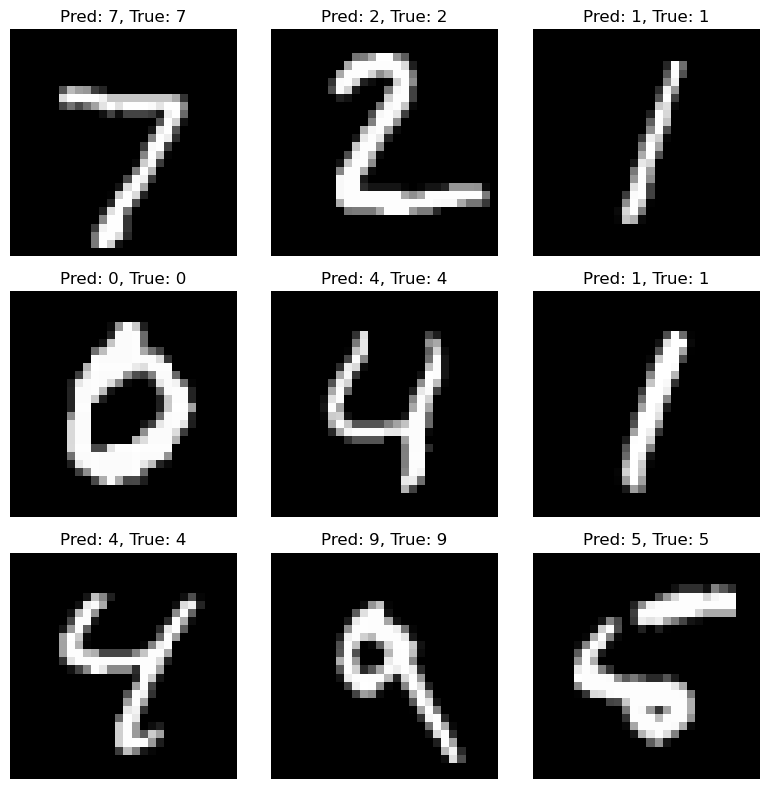

In [11]:
plot_images_with_predictions(images_9, predictions_9, labels_9)

## Jax with Equinox

Equinox allows us to use Jax with a pytorch like syntax based on classes.

In [12]:
import equinox as eqx
import jax
import jax.numpy as jnp
import optax  # https://github.com/deepmind/optax
import torch  # https://pytorch.org
import torchvision  # https://pytorch.org
from jaxtyping import Array, Float, Int, PyTree  # https://github.com/google/jaxtyping

In [13]:
# Hyperparameters

BATCH_SIZE = 64
LEARNING_RATE = 3e-4
STEPS = 300
PRINT_EVERY = 30
SEED = 5678

key = jax.random.PRNGKey(SEED)

In [14]:
class equi_model(eqx.Module):
    layers: list

    def __init__(self, key):
        key1, key2, key3, key4 = jax.random.split(key, 4)
        # Standard CNN setup: convolutional layer, followed by flattening,
        # with a small MLP on top.
        self.layers = [
            eqx.nn.Linear(28*28, 128, key=key3),
            jax.nn.relu,
            eqx.nn.Linear(128, 64, key=key3),
            jax.nn.relu,
            eqx.nn.Linear(64, 10, key=key4),
        ]

    def __call__(self, x: Float[Array, "1 28 28"]) -> Float[Array, "10"]:
        for layer in self.layers:
            x = layer(x)
        return x


key, subkey = jax.random.split(key, 2)
model = equi_model(subkey)

In [22]:
def loss(
    model: equi_model, x: Float[Array, "batch 1 28 28"], y: Int[Array, " batch"]
) -> Float[Array, ""]:
    # Our input has the shape (BATCH_SIZE, 1, 28, 28), but our model operations on
    # a single input input image of shape (1, 28, 28).
    #
    # Therefore, we have to use jax.vmap, which in this case maps our model over the
    # leading (batch) axis.
    pred_y = jax.vmap(model)(x)
    return cross_entropy(y, pred_y)


def cross_entropy(
    y: Int[Array, " batch"], pred_y: Float[Array, "batch"]
) -> Float[Array, ""]:
    # y are the true targets, and should be integers 0-9.
    # pred_y are the logits  predictions.
    labels_onehot = jax.nn.one_hot(labels, num_classes=10)
    return optax.softmax_cross_entropy(logits=logits, labels=labels_onehot).mean()
 

In [23]:
loss = eqx.filter_jit(loss)  # JIT our loss function from earlier!


@eqx.filter_jit
def compute_accuracy(
    model: equi_model, x: Float[Array, "batch 1 28 28"], y: Int[Array, " batch"]
) -> Float[Array, ""]:
    """This function takes as input the current model
    and computes the average accuracy on a batch.
    """
    pred_y = jax.vmap(model)(x)
    pred_y = jnp.argmax(pred_y, axis=1)
    return jnp.mean(y == pred_y)

In [24]:
def evaluate(model: equi_model, val_loader: torch.utils.data.DataLoader):
    """This function evaluates the model on the test dataset,
    computing both the average loss and the average accuracy.
    """
    avg_loss = 0
    avg_acc = 0
    for x, y in val_loader:
        x = x.numpy()
        y = y.numpy()
        # Note that all the JAX operations happen inside `loss` and `compute_accuracy`,
        # and both have JIT wrappers, so this is fast.
        avg_loss += loss(model, x, y)
        avg_acc += compute_accuracy(model, x, y)
    return avg_loss / len(val_loader), avg_acc / len(val_loader)

In [25]:
optim = optax.adamw(LEARNING_RATE)

In [26]:
def train(
    model: equi_model,
    trainloader: torch.utils.data.DataLoader,
    testloader: torch.utils.data.DataLoader,
    optim: optax.GradientTransformation,
    steps: int,
    print_every: int,
) -> equi_model:
    # Just like earlier: It only makes sense to train the arrays in our model,
    # so filter out everything else.
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    # Always wrap everything -- computing gradients, running the optimiser, updating
    # the model -- into a single JIT region. This ensures things run as fast as
    # possible.
    @eqx.filter_jit
    def make_step(
        model: equi_model,
        opt_state: PyTree,
        x: Float[Array, "batch 1 28 28"],
        y: Int[Array, " batch"],
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss)(model, x, y)           
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    # Loop over our training dataset as many times as we need.
    def infinite_trainloader():
        while True:
            yield from trainloader

    for step, (x, y) in zip(range(steps), infinite_trainloader()):
        # PyTorch dataloaders give PyTorch tensors by default,
        # so convert them to NumPy arrays.
        x = x.numpy()
        y = y.numpy()
        model, opt_state, train_loss = make_step(model, opt_state, x, y)
        if (step % print_every) == 0 or (step == steps - 1):
            test_loss, test_accuracy = evaluate(model, testloader)
            print(
                f"{step=}, train_loss={train_loss.item()}, "
                f"test_loss={test_loss.item()}, test_accuracy={test_accuracy.item()}"
            )
    return model

In [27]:
model = train(model, train_loader, val_loader, optim, STEPS, PRINT_EVERY)

TypeError: dot_general requires contracting dimensions to have the same shape, got (784,) and (28,).